# Using formosa

In this notebook we'll explore motif sampling with formosa.

First, import the basic motif sampling functions from the formosa library:

In [72]:
from formosa import maxent_motifs, uniform_motifs, motif_ic

The first two are for sampling; the third is for measuring the motif IC in order to validate our results.  Let's also set up plotting for our notebook:

In [73]:
%matplotlib inline
from matplotlib import pyplot as plt

We'll also set the random seed for reproducibility:

In [74]:
import random
random.seed(1)

## MaxEnt Sampling

Now suppose we'd like to sample decamer motifs, each consisting of 20 sites, such that the average IC is 10 bits.  Let's say we'd like 100000 of them.  Formally speaking, we sample them from the maximum entropy (MaxEnt) distribution over all motifs of dimensions (L=10, N=20) so that mean IC is 10 bits.  We can call the maxent_motifs function this way:

In [75]:
maxent_samples = maxent_motifs(N=20, L=10, desired_ic=10, num_motifs=100000)

Now let's check our samples:

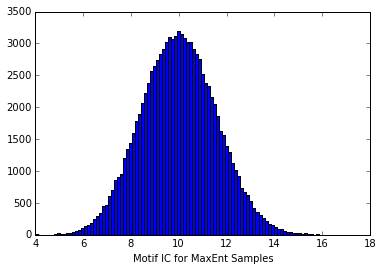

In [76]:
maxent_ics = map(motif_ic, maxent_samples)
_ = plt.hist(maxent_ics,bins=100)
plt.xlabel("Motif IC for MaxEnt Samples")

The distribution of sampled motif ICs appears to be approximately normal, centered at 10 bits.  We can check the mean with a quick confidence interval:

In [77]:
from formosa_utils import mean, sd
from math import sqrt
mu, sigma = mean(maxent_ics), sd(maxent_ics)
coverage = 1.96 * sigma/sqrt(10000)
print "sample mean: %1.3f bits" % mu
print "95%% confidence interval for mean: (%1.3f, %1.3f) (bits)" % (mu - coverage, mu + coverage)

sample mean: 9.999 bits
95% confidence interval for mean: (9.968, 10.029) (bits)


So our mean IC appears to be exactly on target.

## Truncated Uniform Sampling

In our MaxEnt samples we saw that the average IC was exactly what we asked for.  Some motifs, however, had substantially more or less than 10 bits of IC.  For some applications this is a desirable property, but for others it may be more convenient to be able to restrict the samples to a given IC interval.  For these applications we defined the truncated uniform (TU) distribution, which assigns equal probability to mass to all motifs of given dimension having IC $I \pm \epsilon$, for desired IC $I$ and tolerance $\epsilon$.  We can sample them with the uniform_motifs function like this:

In [78]:
tu_samples = uniform_motifs(N=20, L=10, desired_ic=10, epsilon=0.1, num_motifs=10000)

Notice that the TU sampler can sometimes be much slower than the MaxEnt sampler.  This is because the TU sampler implements a rejection sampling algorithm with a MaxEnt sampler as the proposal distribution.  It must exclude all motifs falling outside the desired IC interval. It must also reject some motifs which fall _inside_ it in order to yield a statistically exact sample.  Let's check the results:

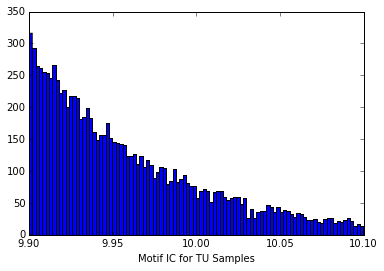

In [95]:
tu_ics = map(motif_ic, tu_samples)
_ = plt.hist(tu_ics,bins=100)
plt.xlabel("Motif IC for TU Samples")

Notice that, in contrast to the MaxEnt samples, the distribution of the TU motif ICs appears to be approximately exponentially distributed over the permissible range of 9.9 to 10.1 bits.  We can check this by overlaying a rough exponential fit to the data.  Although the details of fitting parameters to truncated exponential data are beyond the scope of this notebook, we find that we can achieve a tolerable fit by eye:

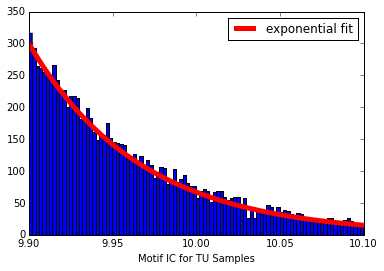

In [106]:
import numpy as np
from math import exp
_ = plt.hist(tu_ics,bins=100)
plt.xlabel("Motif IC for TU Samples")
xs = np.linspace(9.9,10.1,1000)
fit = lambda x:300*exp(-15*(x-9.9))
plt.plot(xs,map(fit,xs),linewidth=5,color='r',label="exponential fit")
plt.legend()

The exponential trend is expected behavior; a distribution that assigns equal probability mass to all motifs with IC between 9.9 and 10.1 bits will appear to be biased towards low IC values simply because there exist more motifs  to be sampled on the low end than on the high end.  Users should bear this phenomenon in mind when sampling from TU distributions.

# Convenience functions: Motif Spoofing

One common workflow is to begin with a biological motif of interest, estimate its motif IC, then generate a set of synthetic replicates for comparison by parametric bootstrapping.  We refer to this operation as "spoofing" for short: given the observed data, we spoof it with a set of synthetic motifs of the same dimensions and same (average or approximate) IC.  We can then compare the statistics of the biological motif to the distribution of those statistics observed in the synthetic replicates.  

Spoofing is accommodated through a set of convenience functions in formosa, which we import below:

In [80]:
from formosa import spoof_maxent_motifs, spoof_uniform_motifs

In recent years, high-throughput methods have enabled the assembly of very large sequence motifs.  For ease of illustration, though, let's consider the collection of LacI binding sites treated by Berg and von Hippel in 1987 [0]:

In [81]:
lacI_motif = ["CTATCACCGGAAGGGATTA",
              "CTAACACCGTGCGTGTTGA",
              "TTACCTCTGGCGGTGATAA",
              "ATACCACTGGCGGTGATAC",
              "TTATCTCTGGCGGTGTTGA",
              "TAACCATCTGCGGTGATAA"]

To generate synthetic MaxEnt controls we can call:

In [82]:
lacI_spoofs = spoof_maxent_motifs(lacI_motif, num_motifs=10000)

(TU motifs can be sampled in a similar way.)  To verify the output, let's compare the IC of the original LacI motif to the IC distribution of the controls:

LacI motif IC: 17.530
sample mean: 17.548 bits
95% confidence interval for mean: (17.503, 17.593) (bits)


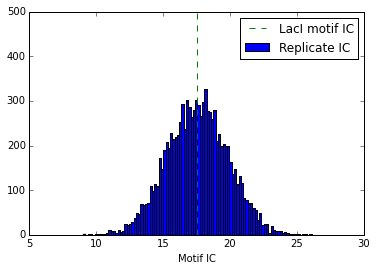

In [83]:
lacI_ic = motif_ic(lacI_motif)
lacI_spoof_ics = map(motif_ic, lacI_spoofs)
_ = plt.hist(lacI_spoof_ics,bins=100,label="Replicate IC")
plt.plot([lacI_ic,lacI_ic],[0,500],linestyle='--',label="LacI motif IC")
plt.xlabel("Motif IC")
plt.legend()
mu, sigma = mean(lacI_spoof_ics), sd(lacI_spoof_ics)
coverage = 1.96 * sigma/sqrt(10000)
print "LacI motif IC: %1.3f" % lacI_ic
print "sample mean: %1.3f bits" % mu
print "95%% confidence interval for mean: (%1.3f, %1.3f) (bits)" % (mu - coverage, mu + coverage)

This indicates good agreement between the observed IC value and those of the replicates.

# References

[0] Berg OG, von Hippel PH. Selection of DNA binding sites by regulatory proteins. Statistical-mechanical theory and application to operators and promoters. J Mol Biol. 1987 Feb;193(4) 723-750. doi:10.1016/0022-2836(87)90354-8. PMID: 3612791.
